In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=3d5fc37435afc99e3ac69140a70149d0d41786b88866692df9fd970e8882e091
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from pyDOE import lhs

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
 # Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.ThermalDiffusivity = model_parameters["ThermalDiffusivity"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        lb = self.LowerBounds
        ub = self.UpperBounds
        x = 2*(x - lb)/(ub - lb) - 1
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def internalEnergyBalanceResidue(self, X, T):

        #alpha = self.ThermalDiffusivity
        alpha = X[:, 2:3] #Last column of the input dataset

        # Compute the derivatives of the output w.r.t. the inputs (space and time) using AD mechanism:
        diff_T = torch.autograd.grad(T, X, create_graph=True, grad_outputs=torch.ones_like(T))[0]
        Tx, Tt = diff_T[:, 0:1], diff_T[:, 1:2]

        # Compute the second derivative of the output w.r.t. the inputs (only space) using AD mechanism:
        Txx = torch.autograd.grad(Tx, X, create_graph=True, grad_outputs=torch.ones_like(T))[0][:, 0:1]

        residue = Tt - alpha*Txx
        return residue

## Problem data

In [4]:
# Properties of pure solid aluminium
k = 210.0 # W/(m K)
C = 900.0 # J/(kg K)
rho = 2700.0 #kg/m^3
alpha_Al = k/(rho*C)

# Boundaries of space and time domains
ti, tf = 0, 1.0 # s
xi, xf = 0, 1.0 # m

# Boundaries for the variation of alpha
alphai, alphaf = 0.01, 0.1

# Non-dimensionalization
#tf *= alpha
#alpha = 1

lb = torch.tensor([xi, ti, alphai])
ub = torch.tensor([xf, tf, alphaf])

# Initial and boundary temperatures
T_ref = 100.
bc_value = bc_value_l = bc_value_r = 300.0/T_ref # K
k1 = np.pi/xf
T_ampl = 100.0/T_ref # K
T0 = lambda x: T_ampl*torch.sin(k1*x) + bc_value # K

## Exact solution

In [7]:
# Exact solution
T_exact = lambda x, t, alpha: T_ampl*np.sin(k1*x)*np.exp(-k1**2*alpha*t) + bc_value

# Grid for evaluation the exact solution
x_test = np.linspace(xi, xf, 1000)
t_test = np.linspace(ti, tf, 1000)
ms_x, ms_t = np.meshgrid(x_test, t_test)
x_test = np.ravel(ms_x).reshape(-1,1)
t_test = np.ravel(ms_t).reshape(-1,1)
alpha_test = 0.1*np.ones_like(x_test)

T_ex_grid = T_exact(x_test, t_test, alpha_test).reshape(ms_x.shape)

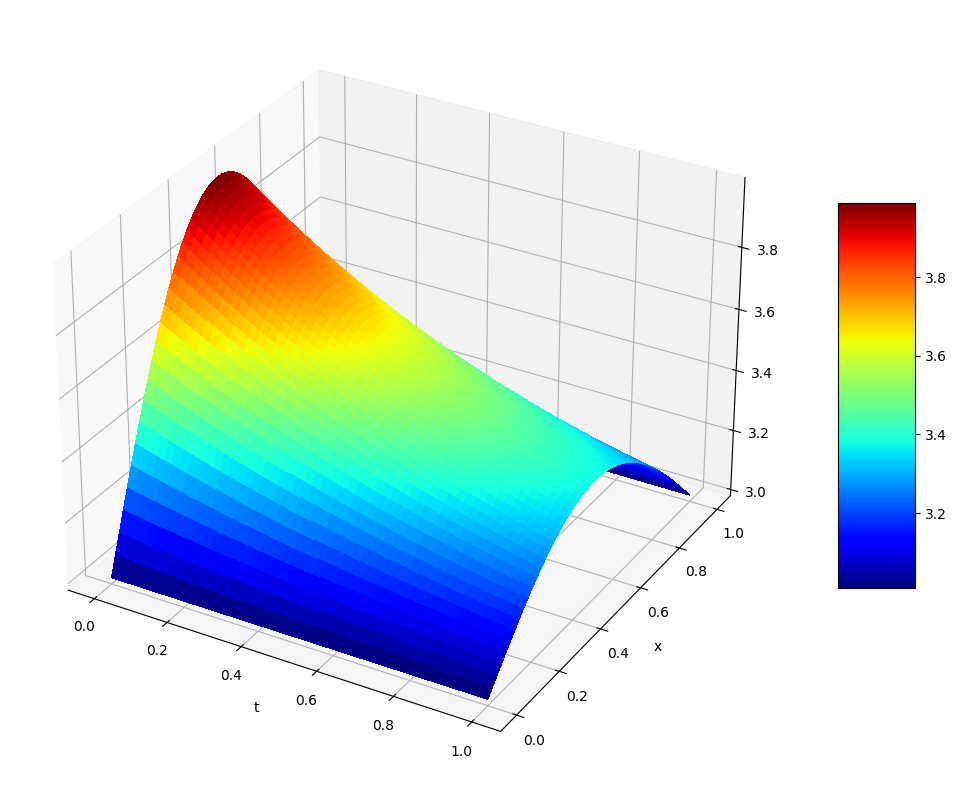

In [8]:
# Plot the exact temperature distribution
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=20, azim=-90)
surf1 = ax.plot_surface(ms_t, ms_x, T_ex_grid, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

## Datasets (collocation points and labelled data points)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx, :]
        target = self.y[idx, :]
        return features, target

In [10]:
# Generate equispaced tensors for both space and time domains to pick from
x_tensor = torch.linspace(xi, xf, 10000, device=device)
t_tensor = torch.linspace(ti, tf, 10000, device=device)
alpha_tensor = torch.linspace(alphai, alphaf, 10000, device=device)

# Number of collocation points
N_dom = 1000 # Number of collocation points for evaluating the residuals
N_bc = 300 # Number of collocation points for computing the boundary conditions
N_ic = 500 # Number of collocation points for computing the initial condition
N_data = 1000 # Number of labelled data points

# Train, validation and testing sets
tags = ["Domain", "BoundaryConditions", "InitialCondition"]
isData = False # Flag to indicate whether the analysis would use labelled data or not

# Initialize list of dataset objects
ds = []

In [11]:
## Collocation points for evaluating the residual of the governing PDE

# Generate collocation points within the domain using Latin Hypercube Sampling (LHS) strategy
X_dom = (lb + (ub - lb)*lhs(3, N_dom)).to(torch.float32).to(device)
y_dom = torch.zeros((N_dom, 1), device=device)

# Generate random collocation points for the left boundary to add to the domain dataset
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_l = t_tensor[idx_bc].view(-1, 1)
x_bc_l = xi*torch.ones((N_bc, 1), device=device)
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
alpha_bc_l = alpha_tensor[idx_bc].view(-1, 1)
X_bc_l = torch.cat([x_bc_l, t_bc_l, alpha_bc_l], axis=1)
y_bc_l = torch.zeros((N_bc, 1), device=device)

# Generate random collocation points for the right boundary to add to the domain dataset
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_r = t_tensor[idx_bc].view(-1, 1)
x_bc_r = xf*torch.ones((N_bc, 1), device=device)
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
alpha_bc_r = alpha_tensor[idx_bc].view(-1, 1)
X_bc_r = torch.cat([x_bc_r, t_bc_r, alpha_bc_r], axis=1)
y_bc_r = torch.zeros((N_bc, 1), device=device)

# Generate collocation points for the initial condition to add to the domain dataset
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
x_ic = x_tensor[idx_ic].view(-1, 1)
t_ic = ti*torch.ones((N_ic, 1), device=device)
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
alpha_ic = alpha_tensor[idx_ic].view(-1, 1)
X_ic = torch.cat([x_ic, t_ic, alpha_ic], axis=1)
y_ic = torch.zeros((N_ic, 1), device=device)

# Concatenate X_dom dataset
X_dom = torch.cat([X_dom, X_bc_l, X_bc_r, X_ic], axis=0)
y_dom = torch.cat([y_dom, y_bc_l, y_bc_r, y_ic], axis=0)
ds.append(CustomDataset(X_dom, y_dom))

In [12]:
X_dom

tensor([[0.5968, 0.1447, 0.0399],
        [0.9308, 0.9462, 0.0814],
        [0.6056, 0.9818, 0.0799],
        ...,
        [0.8922, 0.0000, 0.0301],
        [0.7968, 0.0000, 0.0959],
        [0.3863, 0.0000, 0.0562]], device='cuda:0')

In [13]:
## Collocation points for evaluating the boundary and initial conditions

# Generate random collocation points for the left boundary
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_l = t_tensor[idx_bc].view(-1, 1)
x_bc_l = xi*torch.ones((N_bc, 1), device=device)
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
alpha_bc_l = alpha_tensor[idx_bc].view(-1, 1)
X_bc_l = torch.cat([x_bc_l, t_bc_l, alpha_bc_l], axis=1)
y_bc_l = torch.full((N_bc, 1), bc_value_l)

# Generate random collocation points for the right boundary
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
t_bc_r = t_tensor[idx_bc].view(-1, 1)
x_bc_r = xf*torch.ones((N_bc, 1), device=device)
idx_bc = np.random.choice(t_tensor.size()[0], N_bc, replace=False)
alpha_bc_r = alpha_tensor[idx_bc].view(-1, 1)
X_bc_r = torch.cat([x_bc_r, t_bc_r, alpha_bc_r], axis=1)
y_bc_r = torch.full((N_bc, 1), bc_value_r)

# Concatenate the collocation points of both boundaries
X_bc = torch.cat([X_bc_l, X_bc_r], axis=0)
y_bc = torch.cat([y_bc_l, y_bc_r], axis=0)
ds.append(CustomDataset(X_bc, y_bc))

# Generate collocation points for the initial condition
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
x_ic = x_tensor[idx_ic].view(-1, 1)
t_ic = ti*torch.ones((N_ic, 1), device=device)
idx_ic = np.random.choice(x_tensor.size()[0], N_ic, replace=False)
alpha_ic = alpha_tensor[idx_ic].view(-1, 1)
X_ic = torch.cat([x_ic, t_ic, alpha_ic], axis=1)
y_ic = T0(x_ic)
ds.append(CustomDataset(X_ic, y_ic))

In [14]:
# Generate syntetic temperature labelled data
if isData:
    tags.append("LabelledData")
    omega = 0.01
    sensor_loc = [0.5]
    x_data, t_data, alpha_data = [], [], []
    for loc in sensor_loc:
        idx_data = np.random.choice(x_tensor.size()[0], N_data, replace=False)
        x_data.append(torch.full((N_data, 1), loc, device=device))
        t_data.append(t_tensor[idx_data].view(-1, 1))
        alpha_data.append(alpha_data[idx_data].view(-1, 1))

    X_data = torch.cat([torch.cat(x_data, axis=0), torch.cat(t_data, axis=0)], axis=1)
    exact_temp_data = T_exact(X_data[:, 0].data.cpu().numpy(), X_data[:, 1].data.cpu().numpy(), X_data[:, 2].data.cpu().numpy())
    noisy_temp_data = exact_temp_data.reshape(-1, 1) + omega*np.max(exact_temp_data)*np.random.normal(size=(len(sensor_loc)*N_data, 1))
    y_data = torch.from_numpy(noisy_temp_data).to(torch.float32).to(device)
    ds.append(CustomDataset(X_data, y_data))


In [15]:
# Dictionary of dataset objects
datasets = dict(zip(tags, ds))

## Main execution

In [16]:
# Input dictionary for model instance
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "ThermalDiffusivity": None,
    "InputDimensions": 3,
    "OutputDimensions": 1,
    "NumberOfNeurons": 30,
    "NumberOfHiddenLayers": 5,
    "ActivationFunction": nn.Tanh()
}

In [17]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [18]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [19]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

epochs = 15000
lr = 1e-4
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_train = []
loss_train_dom = []
loss_train_bc = []
loss_train_ic = []
loss_train_data = []
train_keys = ['Overall', 'Domain', 'BC', 'IC', 'Data']
for epoch in range(epochs):
    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        X = (datasets[tag].X).to(device)
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            T = model(X)
            y_hat = model.internalEnergyBalanceResidue(X, T)
            loss = loss_fn(y_hat, y)
            loss_list.append(loss)

        else:
            T = model(X)
            loss = loss_fn(T, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    loss_train_bc.append(loss_list[2].item())
    loss_train_ic.append(loss_list[3].item())
    if isData:
        loss_train_data.append(loss_list[4].item())


    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)

elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


##TRAIN## Adam - Epoch: 0, Overall: 3.87501e+00, Domain: 1.37298e-03, BC: 1.11326e+00, IC: 2.76038e+00, 
##TRAIN## Adam - Epoch: 100, Overall: 2.83996e-01, Domain: 2.36200e-03, BC: 3.88492e-02, IC: 2.42784e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 2.49195e-01, Domain: 6.49420e-03, BC: 7.52182e-02, IC: 1.67482e-01, 
##TRAIN## Adam - Epoch: 300, Overall: 2.37251e-01, Domain: 1.09829e-02, BC: 6.81478e-02, IC: 1.58120e-01, 
##TRAIN## Adam - Epoch: 400, Overall: 2.23375e-01, Domain: 1.29418e-02, BC: 6.26029e-02, IC: 1.47830e-01, 
##TRAIN## Adam - Epoch: 500, Overall: 2.01881e-01, Domain: 1.29419e-02, BC: 5.52653e-02, IC: 1.33674e-01, 
##TRAIN## Adam - Epoch: 600, Overall: 1.68219e-01, Domain: 1.30320e-02, BC: 4.41483e-02, IC: 1.11039e-01, 
##TRAIN## Adam - Epoch: 700, Overall: 1.24951e-01, Domain: 1.66555e-02, BC: 3.00672e-02, IC: 7.82283e-02, 
##TRAIN## Adam - Epoch: 800, Overall: 8.84356e-02, Domain: 2.49045e-02, BC: 1.79532e-02, IC: 4.55779e-02, 
##TRAIN## Adam - Epoch: 900, Overall: 6

## Loss functions

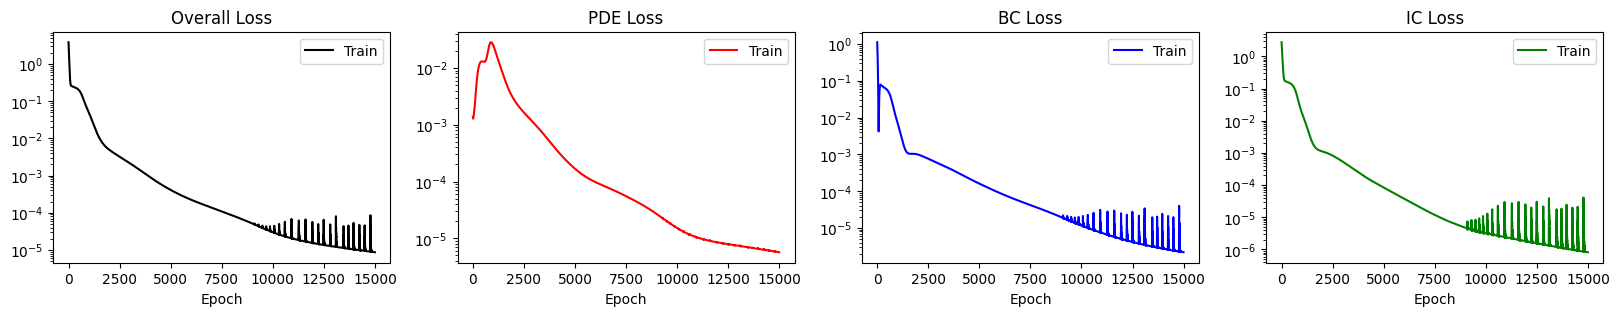

In [20]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss', 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].semilogy(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Prediction

In [27]:
# Definition of tensors from the testing points for evaluating the trained PINN
alpha_test = 0.01*np.ones_like(x_test)
pt_x = torch.from_numpy(x_test).float()
pt_t = torch.from_numpy(t_test).float()
pt_alpha = torch.from_numpy(alpha_test).float()
ms_Tex = T_ref*T_exact(x_test, t_test, alpha_test).reshape(ms_x.shape)

In [28]:
# Predicted solution
X_pred = torch.cat([pt_x, pt_t, pt_alpha], axis=1).to(device)
Tpred = model(X_pred).data.cpu().numpy()
ms_Tpred = T_ref*Tpred.reshape(ms_x.shape)

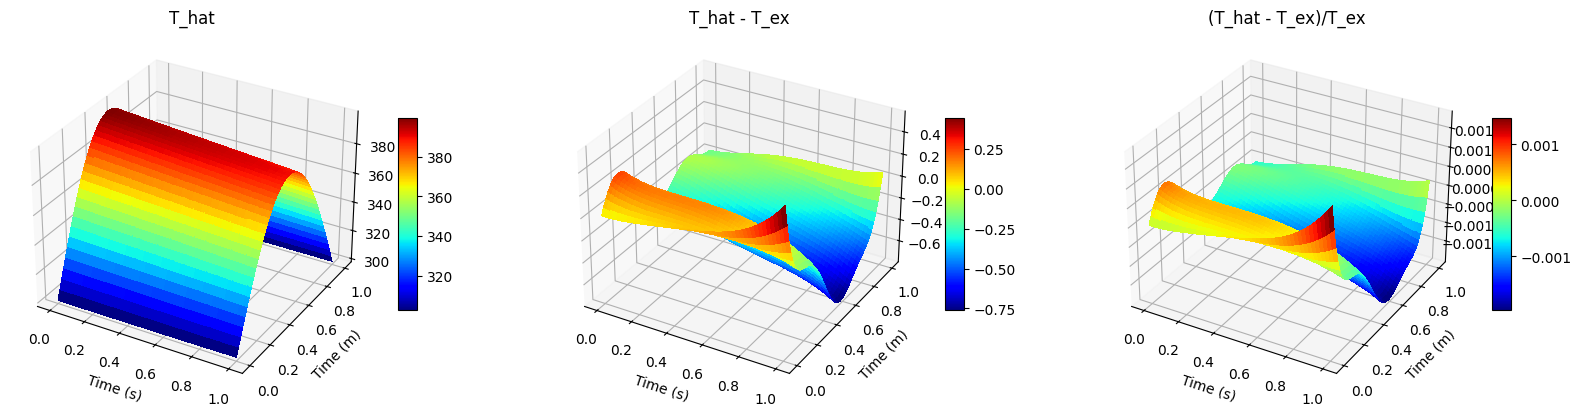

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
ax = axs[0]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat')
ax = axs[1]
surf = ax.plot_surface(ms_t, ms_x, ms_Tpred-ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('T_hat - T_ex')
ax = axs[2]
surf = ax.plot_surface(ms_t, ms_x, (ms_Tpred-ms_Tex)/ms_Tex, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time (m)')
ax.set_title('(T_hat - T_ex)/T_ex')
plt.show()